# **Importing**

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
# data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedKFold,RepeatedStratifiedKFold
from sklearn.compose import ColumnTransformer,make_column_selector
# classifiers
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, StackingClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor

## using imblearn library:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

## metrics:
from sklearn.metrics import accuracy_score,matthews_corrcoef, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

# statistical tests
from scipy.stats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant


In [ ]:
print("numpy", np.__version__)
print("pandas", pd.__version__)
print("seaborn", sns.__version__)


numpy 1.26.4
pandas 2.1.4
seaborn 0.13.1


In [ ]:
data=pd.read_csv('/content/credit_risk_dataset.csv')

# **EDA**

## **Understanding the data**

In [ ]:
print(f"shape of the data -> {data.shape}")

shape of the data -> (32581, 12)


In [ ]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [ ]:
print("Median income in dataset -> ",data["person_income"].median())

Median income in dataset ->  55000.0


In [ ]:
print("Average income in dataset -> ",data["person_income"].mean())

Average income in dataset ->  66074.84846996715


- The average income in India is ₹3,87,500, but the income and loan amount in the dataset appear to be in a different currency, leading to a scale mismatch.
- The discrepancy suggests that the income and loan data align more closely with the average income in the USA rather than India, indicating the dataset might be based on US financial figures.

In [ ]:
print("Avg Loan Amount on the basis of loan intent")
print(data.groupby(['loan_intent'])['loan_amnt'].mean().sort_values())
print("Avg person income on the basis of loan intent")
print(data.groupby(['loan_intent'])['person_income'].mean().sort_values())

Avg Loan Amount on the basis of loan intent
loan_intent
MEDICAL               9259.582441
EDUCATION             9482.678599
PERSONAL              9573.772867
VENTURE               9583.777758
DEBTCONSOLIDATION     9594.886800
HOMEIMPROVEMENT      10360.520111
Name: loan_amnt, dtype: float64
Avg person income on the basis of loan intent
loan_intent
MEDICAL              61437.227145
EDUCATION            64135.199132
VENTURE              66386.574576
DEBTCONSOLIDATION    66470.876247
PERSONAL             67864.141279
HOMEIMPROVEMENT      73549.470458
Name: person_income, dtype: float64


In [ ]:
print("Avg Interest Rate for each type of loan")
print(data.groupby(['loan_intent'])['loan_int_rate'].mean().sort_values())

Avg Interest Rate for each type of loan
loan_intent
VENTURE              10.948275
EDUCATION            10.950261
DEBTCONSOLIDATION    10.983268
PERSONAL             10.998221
MEDICAL              11.060194
HOMEIMPROVEMENT      11.201152
Name: loan_int_rate, dtype: float64


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [ ]:
data[data.duplicated()].head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15989,23,90000,MORTGAGE,7.0,EDUCATION,B,8000,10.36,0,0.09,N,3
15995,24,48000,MORTGAGE,4.0,MEDICAL,A,4000,5.42,0,0.08,N,4
16025,24,10000,RENT,8.0,PERSONAL,A,3000,7.90,1,0.30,N,3
16028,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.88,0,0.15,N,4


**Dropping duplicates**

In [ ]:
data.drop_duplicates(inplace=True)
print(f"shape after dropping duplicates -> {data.shape}")

shape after dropping duplicates -> (32416, 12)


In [ ]:
ncols=[]
ccols=[]

for i in data.columns:
  if data[i].dtype!='object':
    ncols.append(i)
  else:
    ccols.append(i)


print(f"There are ,{len(ncols)},numerical columns")
for i in ncols:
  print(i)

print('-'*45)

print(f"There are ,{len(ccols)},categorical columns")
for i in ccols:
  print(i)
# knowing columns

There are ,8,numerical columns
person_age
person_income
person_emp_length
loan_amnt
loan_int_rate
loan_status
loan_percent_income
cb_person_cred_hist_length
---------------------------------------------
There are ,4,categorical columns
person_home_ownership
loan_intent
loan_grade
cb_person_default_on_file


In [ ]:
for i in ccols:
  print(i, data[i].nunique())
  print(data[i].value_counts(normalize=True)*100)
  print('-'*45)
  #unique value distribution in categorical columns

person_home_ownership 4
person_home_ownership
RENT        50.524432
MORTGAGE    41.241979
OWN          7.906589
OTHER        0.326999
Name: proportion, dtype: float64
---------------------------------------------
loan_intent 6
loan_intent
EDUCATION            19.777270
MEDICAL              18.638944
VENTURE              17.528381
PERSONAL             16.960760
DEBTCONSOLIDATION    16.007527
HOMEIMPROVEMENT      11.087117
Name: proportion, dtype: float64
---------------------------------------------
loan_grade 7
loan_grade
A    33.017646
B    32.042818
C    19.860563
D    11.167325
E     2.970755
F     0.743460
G     0.197433
Name: proportion, dtype: float64
---------------------------------------------
cb_person_default_on_file 2
cb_person_default_on_file
N    82.323544
Y    17.676456
Name: proportion, dtype: float64
---------------------------------------------


## **Missing values**

In [ ]:
data.isnull().sum()/data.shape[0]*100
#percentage of data missing

,0
person_age,0.000000
person_income,0.000000
person_home_ownership,0.000000
person_emp_length,2.736303
loan_intent,0.000000
loan_grade,0.000000
loan_amnt,0.000000
loan_int_rate,9.547754
loan_status,0.000000
loan_percent_income,0.000000


- two columns have missing values **person_emp_length** and **loan_int_rate**

**Understanding the type of missing data**

There are 3 types of missing data:
1. **MCAR**(Missing completely at random) - The likelihood of a value being missing is unrelated to any other data. Missingness is purely random.
2. **MAR**(Missing at random) - The likelihood of a value being missing is related to observed data but not to the value itself. For example, if income data is missing more frequently in certain age groups, but the missingness is related to age (which is observed) rather than the income value itself.
3. **MNAR**(Missing not at random) - The likelihood of a value being missing is related to the value itself or its missingness mechanism. For example, if people with very high incomes are less likely to report their income.

The imputation technique can be decided on the basis of these types for best results

<Axes: >

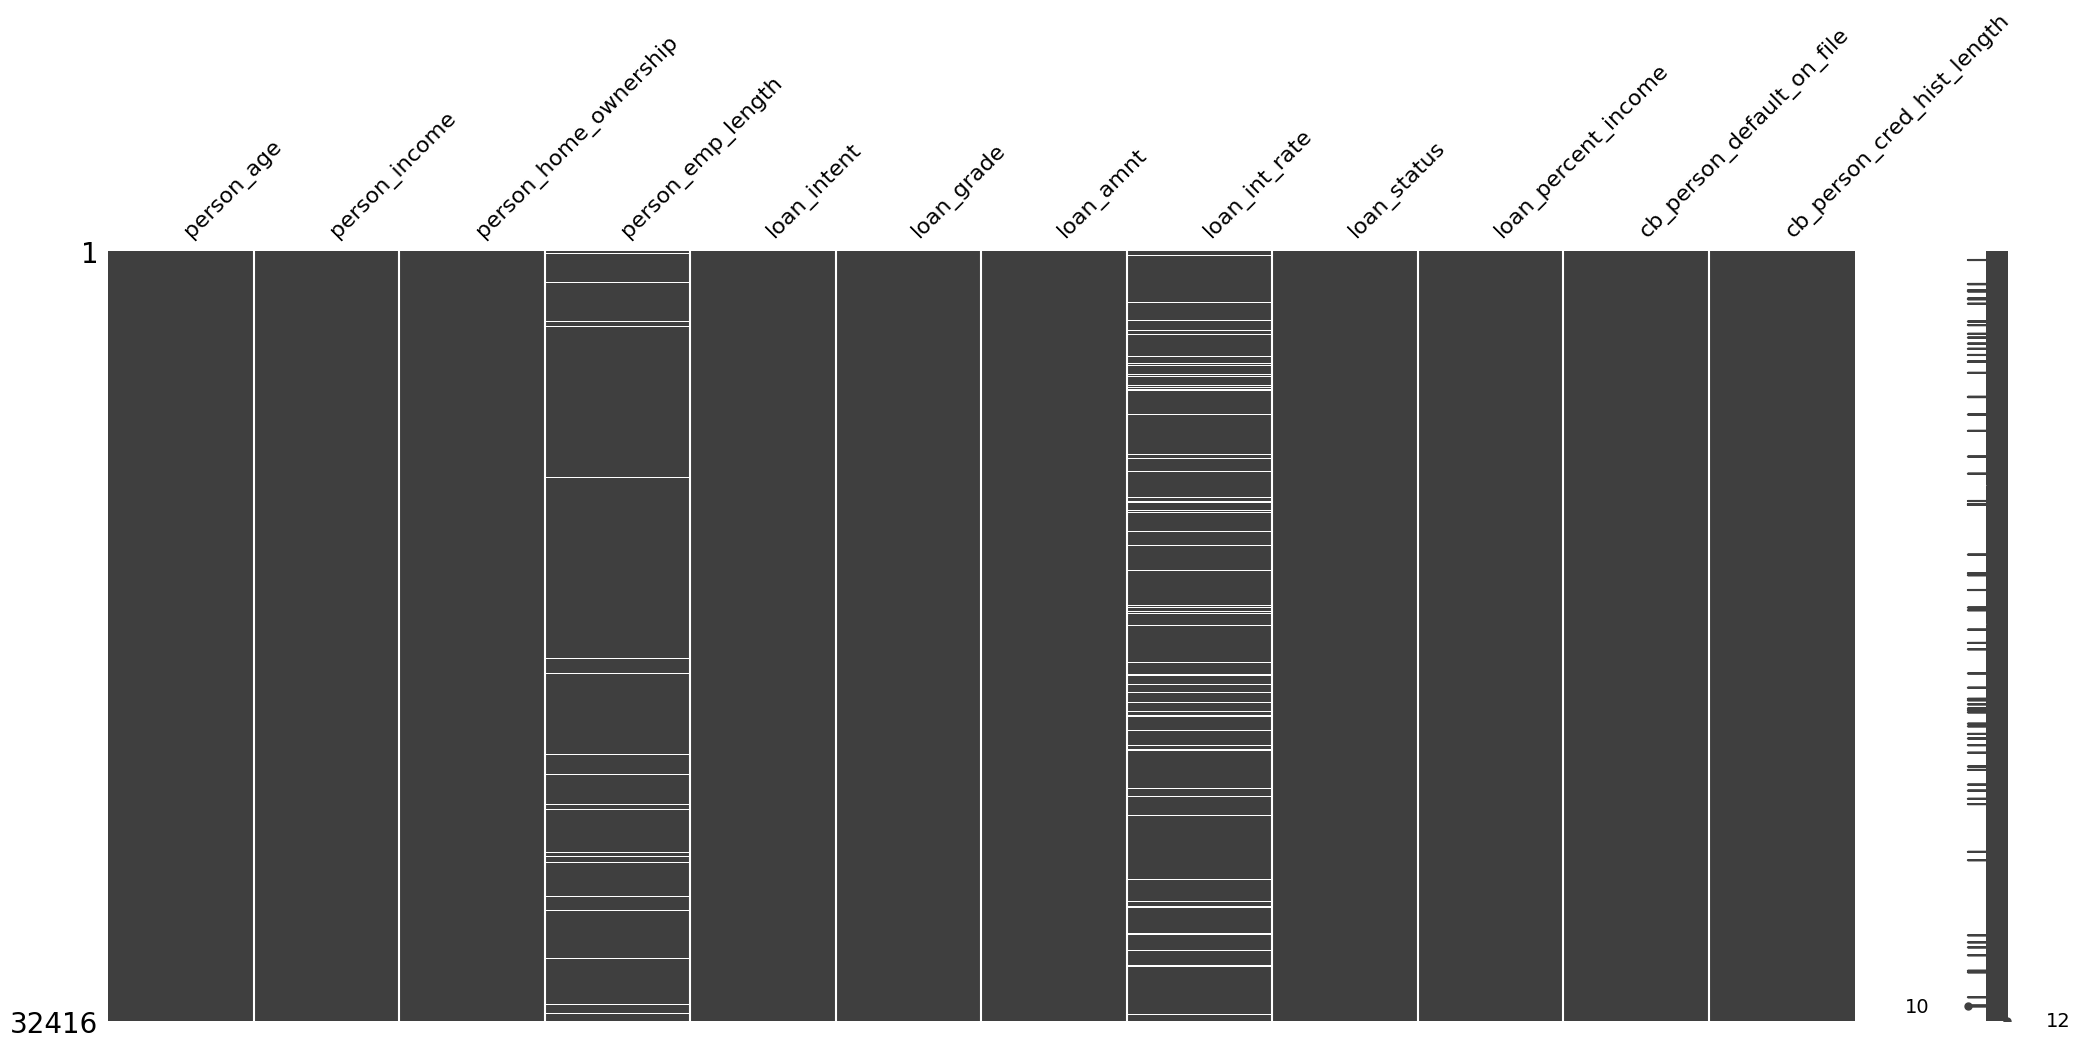

In [ ]:
import missingno as msno
msno.matrix(data)


- White lines represent missing values
- As the distribution of missing values does not apprear to be random the missing data is not MCAR

<Axes: >

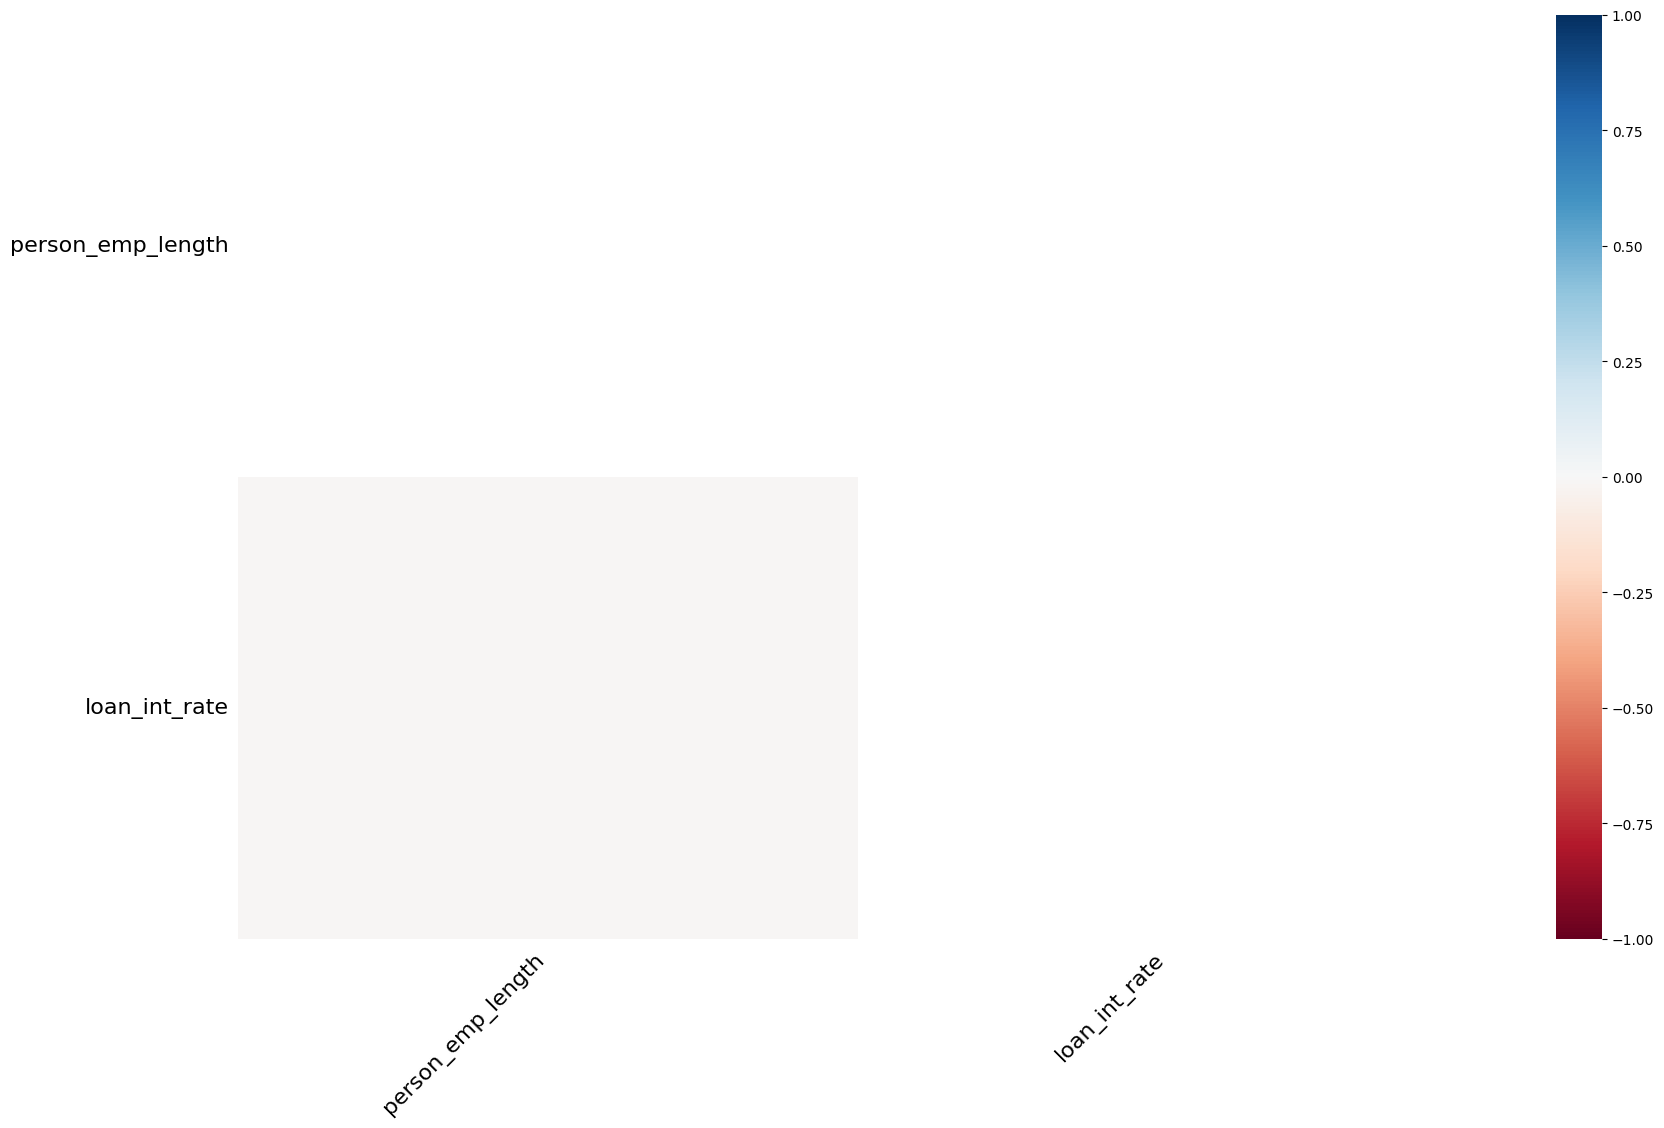

In [ ]:
msno.heatmap(data)

- There is no correlation between missing values

In [ ]:
ncols.remove("person_emp_length")
ncols.remove("loan_int_rate")

In [ ]:
ncols

['person_age',
 'person_income',
 'loan_amnt',
 'loan_status',
 'loan_percent_income',
 'cb_person_cred_hist_length']

### T-test for loan_int_rate

In [ ]:
# Create a binary indicator for missing values
data['missing_rate'] = data['loan_int_rate'].isnull().astype(int)

# Separate the data into two groups
missing_group = data[data['missing_rate'] == 1][['person_age', 'person_income', 'loan_amnt', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length']]
non_missing_group = data[data['missing_rate'] == 0][['person_age', 'person_income', 'loan_amnt', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length']]

# Perform the T-test
t_stat, p_value = ttest_ind(missing_group, non_missing_group)
print(f'T-statistic: {t_stat},\n P-value: {p_value}')


T-statistic: [ 1.78476088  0.55295542  0.54432121 -1.63874441  0.56739385  2.2073697 ],
 P-value: [0.07430946 0.58029775 0.5862242  0.10127621 0.57045056 0.02729522]


almost all p_values > 0.05 which suggests there is no substantial difference between the means of the two groups, indicating that the missingness might be related to other observed variables rather than the values themselves (**potentially MAR**)

### T-test for person_emp_length

In [ ]:
# Create a binary indicator for missing values
data['missing_emp'] = data['person_emp_length'].isnull().astype(int)

# Separate the data into two groups
missing_group = data[data['missing_rate'] == 1][['person_age', 'person_income', 'loan_amnt', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length']]
non_missing_group = data[data['missing_rate'] == 0][['person_age', 'person_income', 'loan_amnt', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length']]

# Perform the T-test
t_stat, p_value = ttest_ind(missing_group, non_missing_group)
print(f'T-statistic: {t_stat},\n P-value: {p_value}')


T-statistic: [ 1.78476088  0.55295542  0.54432121 -1.63874441  0.56739385  2.2073697 ],
 P-value: [0.07430946 0.58029775 0.5862242  0.10127621 0.57045056 0.02729522]


almost all p_values > 0.05 which suggests there is no substantial difference between the means of the two groups, indicating that the missingness might be related to other observed variables rather than the values themselves (**potentially MAR**)

- As the data is MAR(missing at random) IterativeImputer is the best technique to impute values

In [ ]:
data.drop(['missing_rate','missing_emp'],axis=1,inplace=True)
print(data.columns)
print(len(data.columns))

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')
12


In [ ]:
data.groupby(['loan_status'])['person_emp_length'].apply(lambda x: x.isnull().sum())

,person_emp_length
loan_status,
0,606
1,281


In [ ]:
data.groupby(['loan_status'])['loan_int_rate'].apply(lambda x: x.isnull().sum())

,loan_int_rate
loan_status,
0,2454
1,641


**The data is imbalanced**

In [ ]:
data['loan_status'].value_counts(normalize=True)

,proportion
loan_status,
0,0.781312
1,0.218688


## **Outliers**

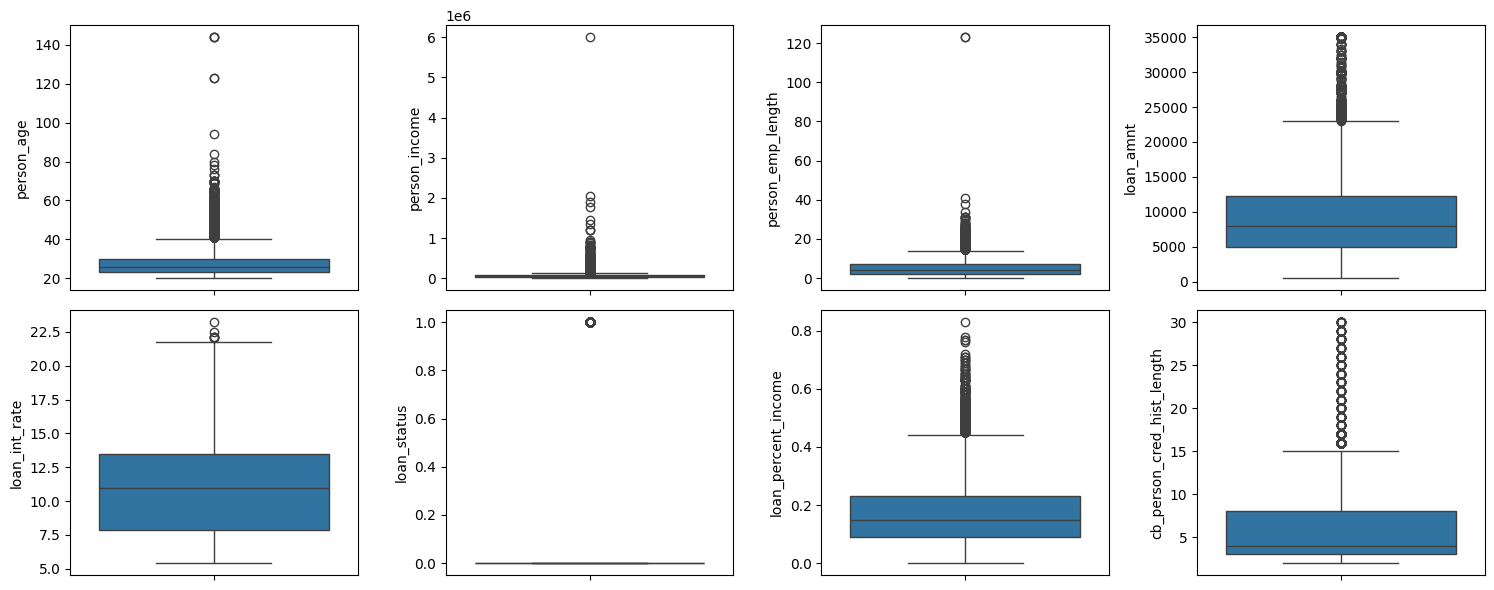

In [ ]:
%matplotlib inline

fig, axes = plt.subplots(2, len(ncols)//2, figsize=(15, 6))

for i, col in enumerate(ncols):
    ax = axes[i // (len(ncols) // 2), i % (len(ncols) // 2)] # calculate the correct index for the axes object
    sns.boxplot(data[col], ax=ax)

plt.tight_layout()
plt.show()

## **Distribution**



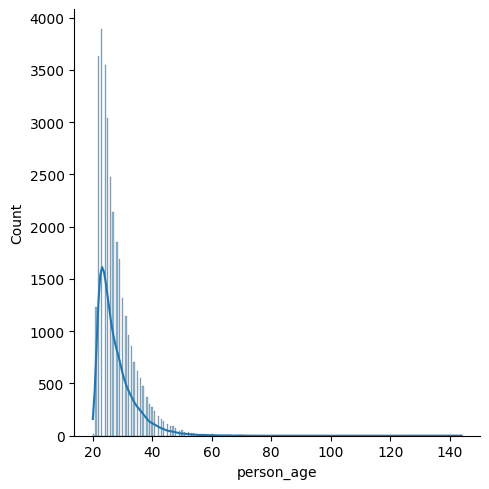

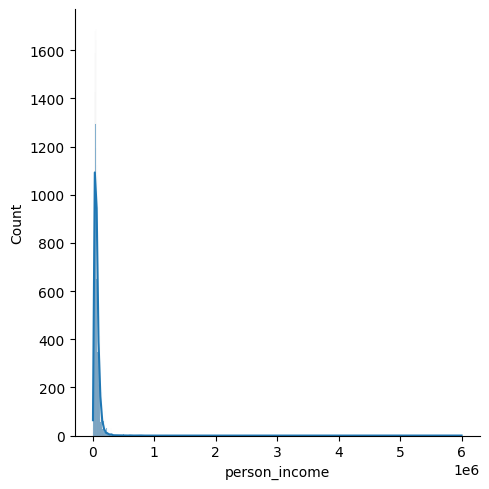

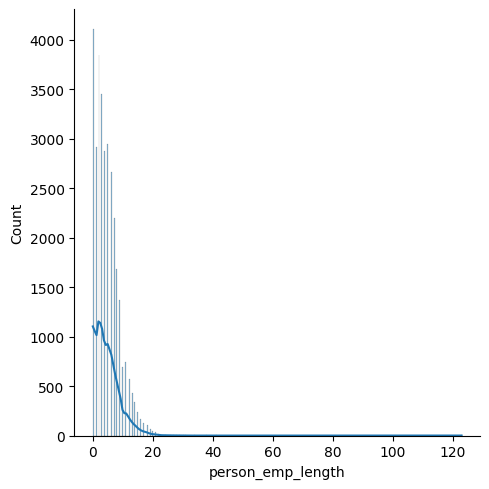

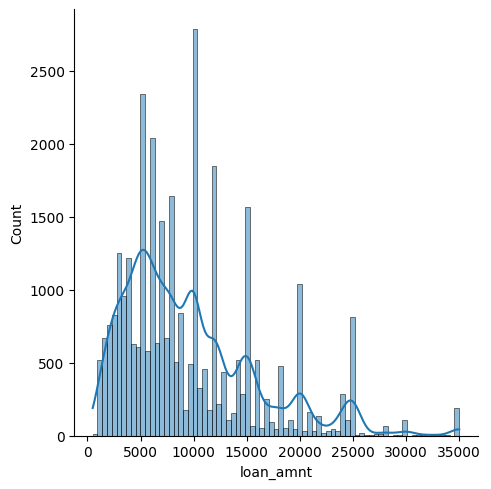

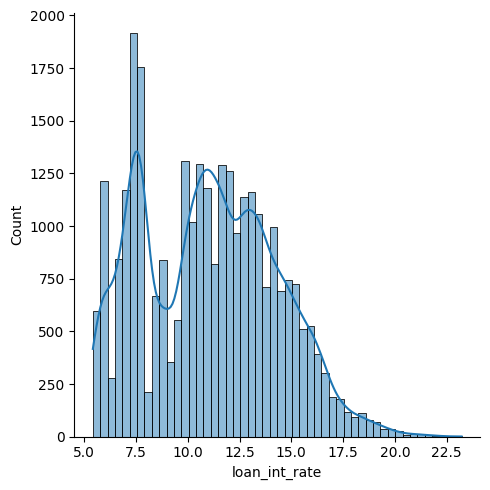

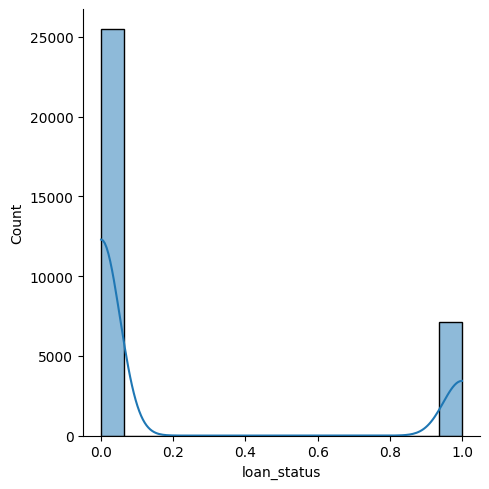

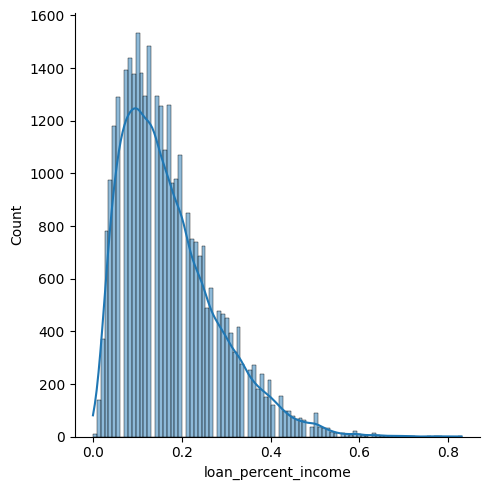

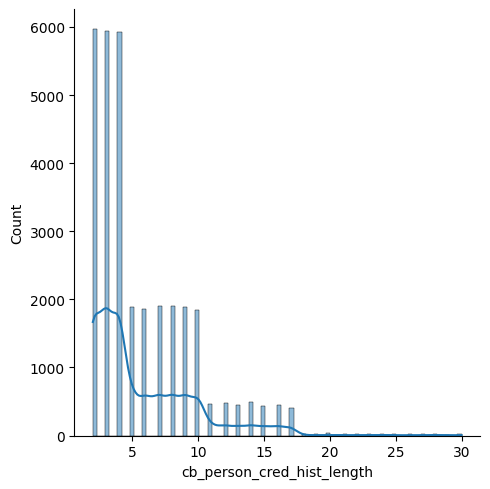

In [ ]:
%matplotlib inline

for i in data.columns:
  if data[i].dtype!='object':
    sns.displot(data[i], kde=True)
    plt.fig_size=(6,3)
    # plt.show()


- as the data is normally distributed and has outliers Standardization should be used

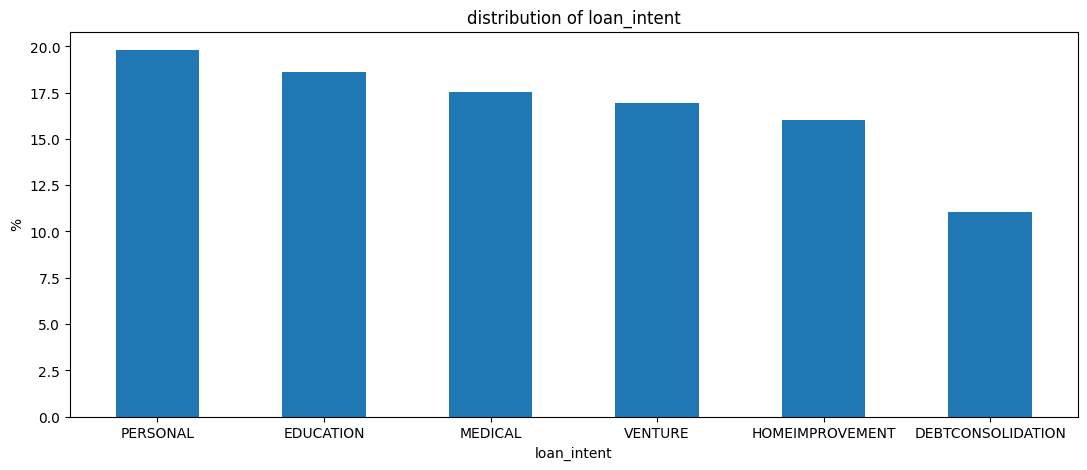

In [ ]:
hori=data['loan_intent'].unique()
vert=data['loan_intent'].value_counts(normalize=True)*100

plt.figure(figsize=(13, 5))
plt.bar(hori,vert, width=0.5)
plt.xlabel('loan_intent')
plt.ylabel('%')
plt.title('distribution of loan_intent')
plt.show()
#The loan intent has a uniform distribution

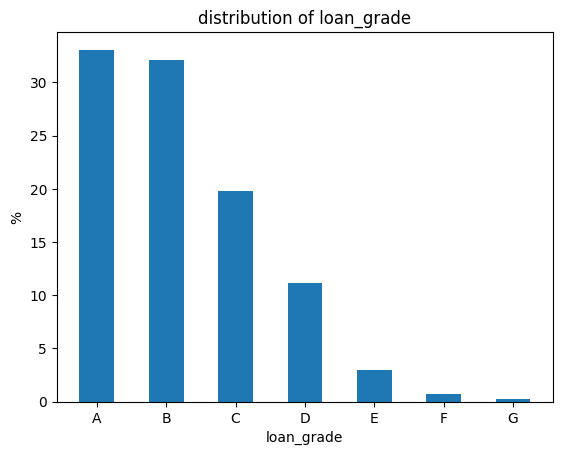

In [ ]:
plt.bar(data['loan_grade'].value_counts().index, data['loan_grade'].value_counts(normalize=True)*100, width=0.5)
plt.xlabel('loan_grade')
plt.ylabel('%')
plt.title('distribution of loan_grade')
plt.show()
#The loan grade has a imbalanced distribution

## **Correlation**

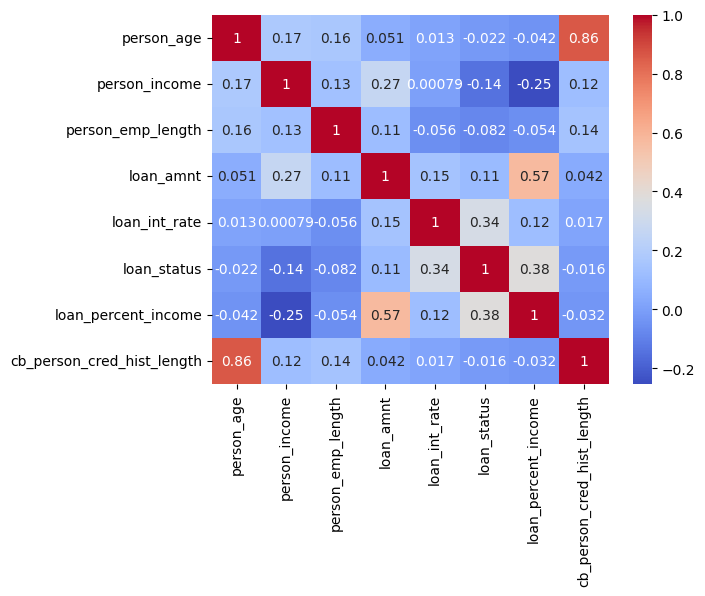

In [ ]:
# Calculate the correlation matrix
corr_matrix = data.select_dtypes(include=np.number).corr()

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

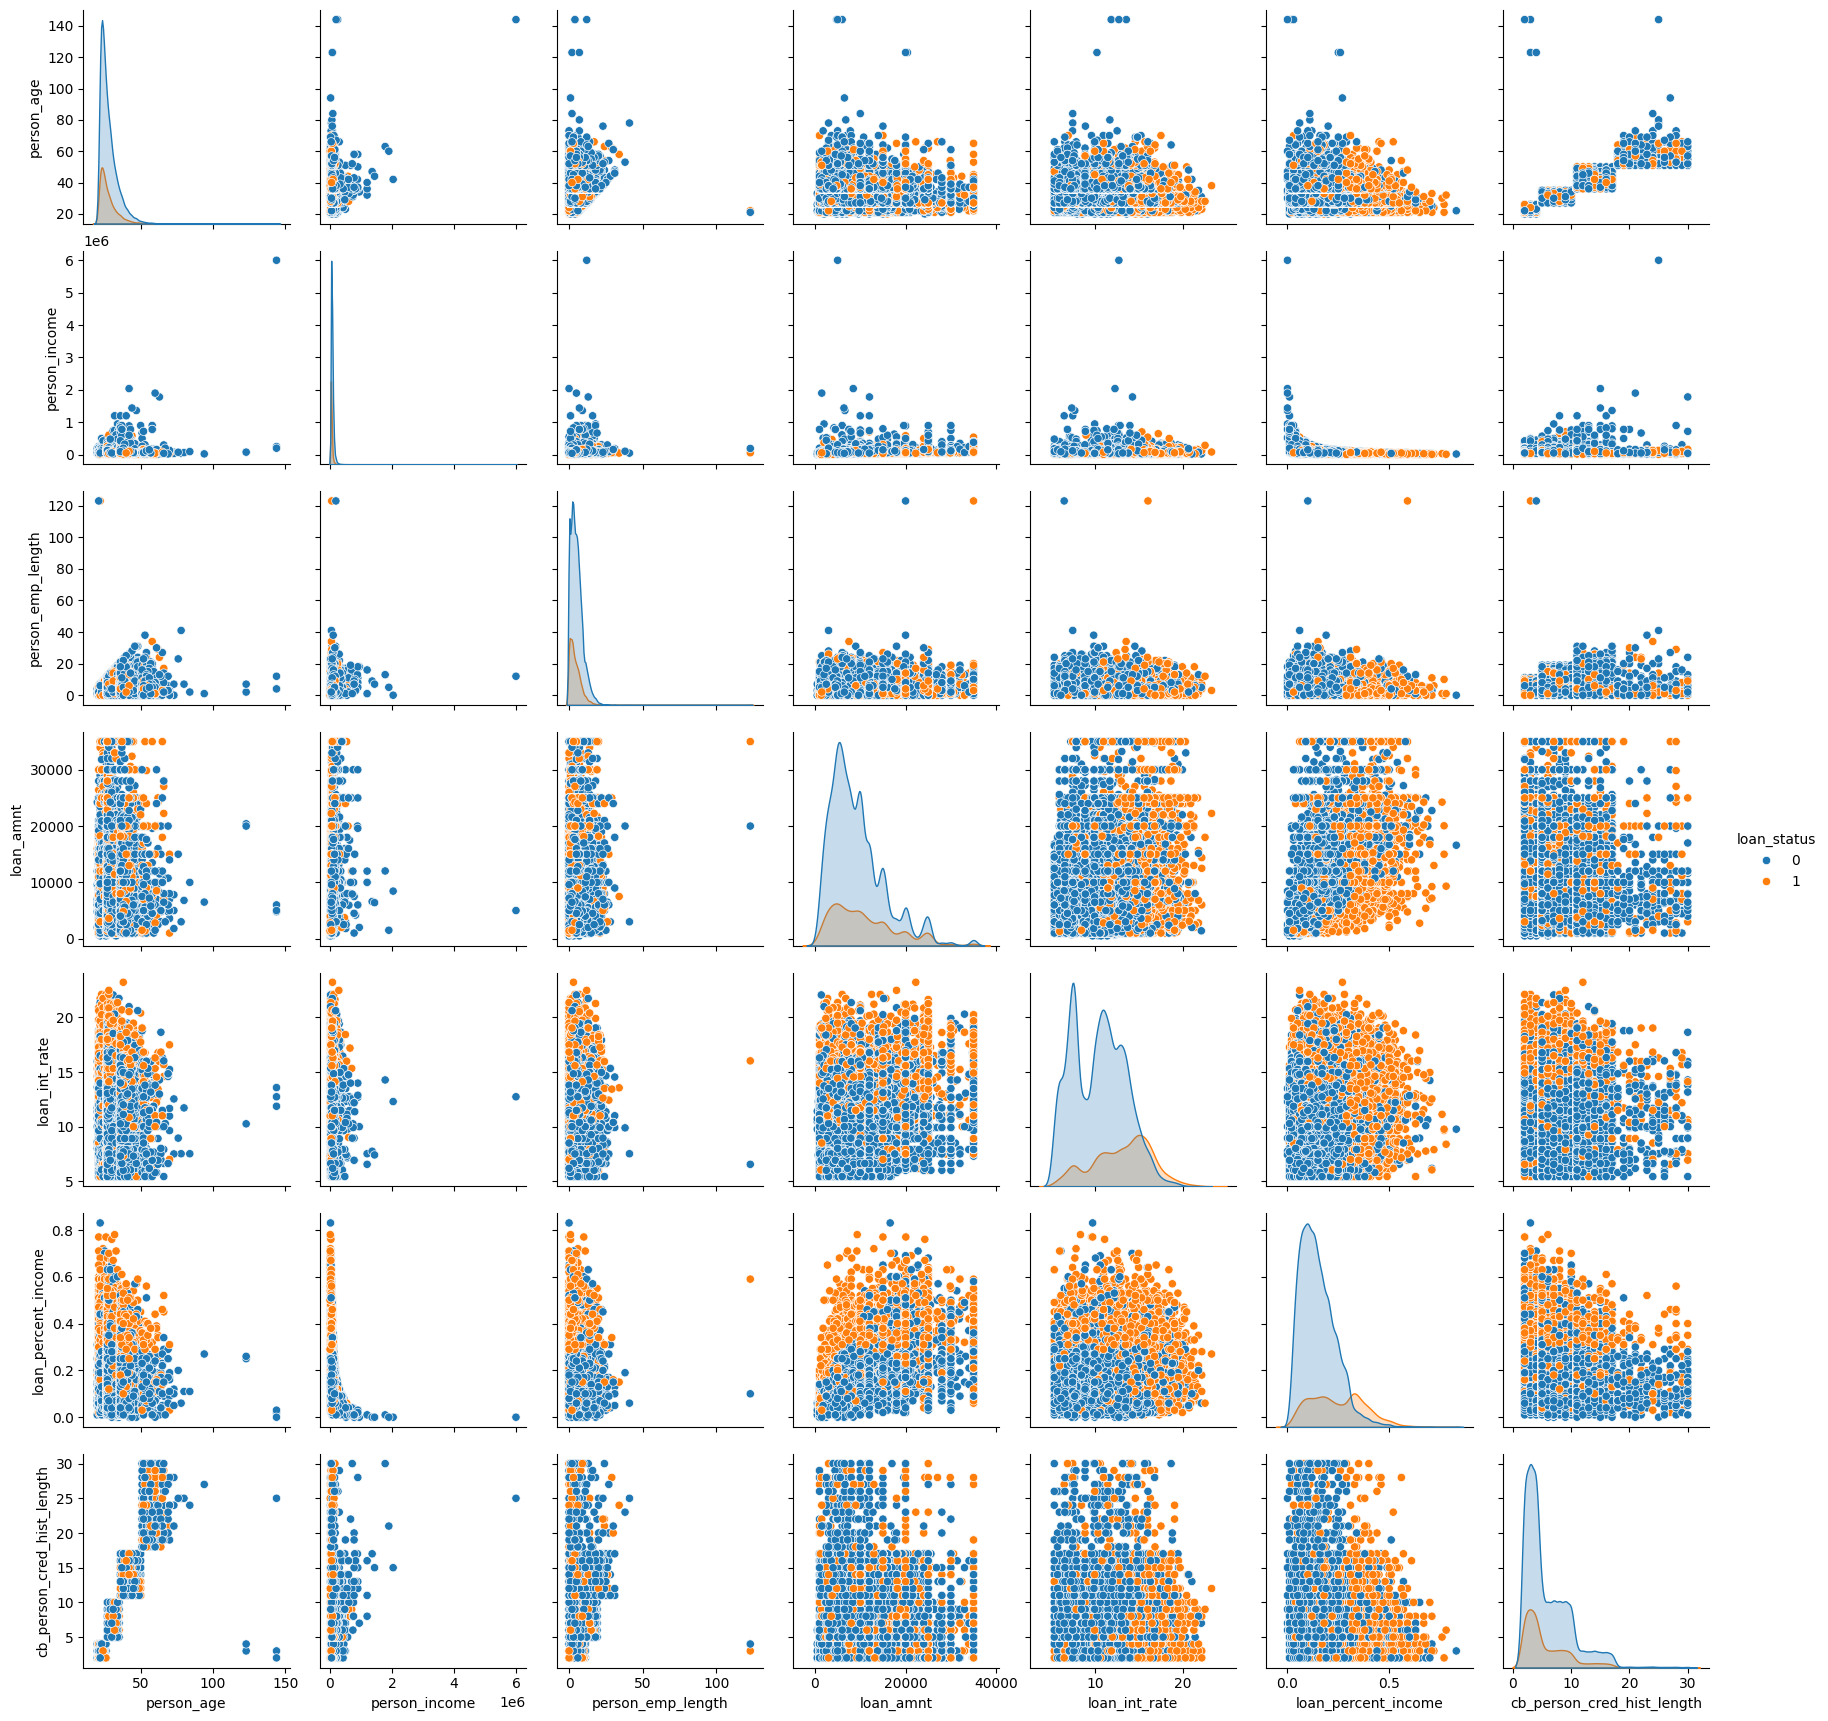

In [ ]:
sns.pairplot(data,hue="loan_status")

In [ ]:
data['loan_status'].corr(data['loan_int_rate'])

0.3351326114498799

## **Multicollinearity**

In [ ]:
ccols

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [ ]:
ncols.append('loan_int_rate')
ncols.append('person_emp_length')

In [ ]:
ncols

['person_age',
 'person_income',
 'loan_amnt',
 'loan_status',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'loan_int_rate',
 'person_emp_length']

In [ ]:

encoder = OneHotEncoder(drop='first')  # drop='first' to avoid multicollinearity
encoded_categorical_data = encoder.fit_transform(data[ccols]).toarray()

# create a dataframe for the encoded categorical variables
encoded_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(ccols))

# combine numerical columns with the encoded categorical columns
combined_data = pd.concat([data[ncols], encoded_df], axis=1)

# calculate VIF for each feature
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = dataframe.columns


    # drop rows with NaN values
    dataframe = dataframe.dropna()
    vif_data['VIF'] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

vif_data = calculate_vif(combined_data)
print("Initial VIF:\n", vif_data)

# Feature selection based on VIF
def select_features_based_on_vif(dataframe, threshold=5.0):
    while True:
        vif_data = calculate_vif(dataframe)
        max_vif = vif_data['VIF'].max()
        if max_vif > threshold:
            # remove feature with highest VIF
            feature_to_remove = vif_data.sort_values('VIF', ascending=False).iloc[0]['Feature']
            dataframe = dataframe.drop(columns=[feature_to_remove])
            print(f"Removed feature: {feature_to_remove} with VIF: {max_vif}")
        else:
            break
    return dataframe

selected_features = select_features_based_on_vif(combined_data)
print("Selected Features:\n", selected_features.columns)

Initial VIF:
                         Feature        VIF
0                    person_age  52.143032
1                 person_income   3.238355
2                     loan_amnt   7.631449
3                   loan_status   1.982233
4           loan_percent_income   8.668841
5    cb_person_cred_hist_length   9.380111
6                 loan_int_rate  65.641520
7             person_emp_length   2.557137
8   person_home_ownership_OTHER   1.010689
9     person_home_ownership_OWN   1.250815
10   person_home_ownership_RENT   2.628265
11        loan_intent_EDUCATION   2.190530
12  loan_intent_HOMEIMPROVEMENT   1.690180
13          loan_intent_MEDICAL   2.112051
14         loan_intent_PERSONAL   2.031186
15          loan_intent_VENTURE   2.085682
16                 loan_grade_B   4.487289
17                 loan_grade_C   6.278230
18                 loan_grade_D   5.726017
19                 loan_grade_E   2.709529
20                 loan_grade_F   1.537433
21                 loan_grade_G   1.2031

# **PREPROCESSING**

## Feature Selection

Deleting **loan_int_rate** because -
- interest rate is decided post the decision of providing loan or not based on risk factor


The model will be trained on tree based classifiers which are not sensitive to multicollinearity. So feature selection on the basis of multicollinearity will not make sense

In [ ]:
data.drop(['loan_int_rate'],axis=1,inplace=True)

In [ ]:
len(data.columns)

11

## Splitting the data conserving the imbalance

In [ ]:
X, X_test, y, y_test = train_test_split(data.drop(columns=['loan_status']), data['loan_status'],
                                        random_state=42,  test_size=0.2, stratify=data['loan_status'],
                                        shuffle=True)
#conserving the proportion of imbalanced data in train and test data

In [ ]:
print("Train data shape - ", X.shape)
print("Test data shape - ", X_test.shape)

Train data shape -  (25932, 10)
Test data shape -  (6484, 10)


## Outlier removal

**REMOVING AGE >75**
**REMOVING EMP_LENGTH > 60**

In [ ]:
X=X[X['person_age']<=80]
X=X[X['person_emp_length']<=60]

X.shape

(25196, 10)

In [ ]:
y=y[X.index]
y.shape

(25196,)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32416 non-null  int64  
 1   person_income               32416 non-null  int64  
 2   person_home_ownership       32416 non-null  object 
 3   person_emp_length           31529 non-null  float64
 4   loan_intent                 32416 non-null  object 
 5   loan_grade                  32416 non-null  object 
 6   loan_amnt                   32416 non-null  int64  
 7   loan_status                 32416 non-null  int64  
 8   loan_percent_income         32416 non-null  float64
 9   cb_person_default_on_file   32416 non-null  object 
 10  cb_person_cred_hist_length  32416 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 3.0+ MB


In [ ]:
X.shape

(25196, 10)

# **CREATING PIPELINE**

In [ ]:
### 1. Creating a pipeline for numerical columns:
num_pipe = Pipeline([
    ('impute', IterativeImputer()),     #MICE (Multivariate Imputation by Chained Equations)
    ('scale', StandardScaler()),
])

ct = ColumnTransformer([
    ('num_pipe', num_pipe, make_column_selector(dtype_include=np.number)),
    ('cat_cols', OneHotEncoder(drop='first',sparse=False, handle_unknown='ignore'), make_column_selector(dtype_include=['object']))
], remainder='passthrough')  # ‘ignore’ : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros. In the inverse transform, an unknown category will be denoted as None.

# for catboost without encoding
ct2 = ColumnTransformer([
    ('num_pipe', num_pipe, make_column_selector(dtype_include=np.number)),
    ('cat_cols2','passthrough',make_column_selector(dtype_include=['object']))

], remainder='passthrough')



In [ ]:
# ct2.fit(X)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_pipe',
                                 Pipeline(steps=[('impute', IterativeImputer()),
                                                 ('scale', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7c54c623d210>),
                                ('cat_cols2', 'passthrough',
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7c54c623c8e0>)])

In [ ]:
# ct2.get_feature_names_out()

array(['num_pipe__person_age', 'num_pipe__person_income',
       'num_pipe__person_emp_length', 'num_pipe__loan_amnt',
       'num_pipe__loan_percent_income',
       'num_pipe__cb_person_cred_hist_length',
       'cat_cols2__person_home_ownership', 'cat_cols2__loan_intent',
       'cat_cols2__loan_grade', 'cat_cols2__cb_person_default_on_file'],
      dtype=object)

# **HYPERPARAMETER TUNING**

### XGB & LightGBM

In [ ]:
grid = {
    XGBClassifier():
    {'model__n_estimators':[i*100 for i in range(10)],
     'model__max_depth':[6,8,10,12,14,16],  # max_depth of decision trees
     'model__learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
     'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}, # chossing estimator for iterative imputer

    LGBMClassifier():
    {'model__n_estimators':[300,400,500],
     'model__learning_rate':[0.001,0.01,0.1,1,10],
     'model__boosting_type': ['gbdt', 'goss', 'dart'],
     'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}

    }

In [ ]:
full_df = pd.DataFrame()
best_algos = {}

# ## Changing the ordering of the columns for ease of understanding:
X=X[X.select_dtypes(include=[np.number]).columns.append(X.select_dtypes(exclude=[np.number]).columns)]
# print(X.columns)

In [ ]:
for i, name in enumerate(X.columns):
  print(i,name)

0 person_age
1 person_income
2 person_emp_length
3 loan_amnt
4 loan_percent_income
5 cb_person_cred_hist_length
6 person_home_ownership
7 loan_intent
8 loan_grade
9 cb_person_default_on_file


In [ ]:
for model, param in grid.items():

    # smote object:
    smt = SMOTE(random_state=42)

    pipe = Pipeline([
    ('coltf', ct),     #ct for the column transformer for preprocessing
    ('smote', smt),
    ('model', model)
    ])

    print(f"Training {model}!!\n")
    # Conducting a Randomized Search to find the best optimal hyperparamaters:

    gs = RandomizedSearchCV(estimator=pipe, param_distributions=param, scoring='accuracy',verbose=3, n_iter=5, random_state=42)

    print("Fitting!!\n")

    gs.fit(X, y)

    print("Gathering Results!!\n")
    all_res = pd.DataFrame(gs.cv_results_)

    temp = all_res.loc[:, ['params', 'mean_test_score']]
    algo_name = str(model).split('(')[0]
    temp['algo'] = algo_name

    full_df = pd.concat([full_df, temp], ignore_index=True)
    best_algos[algo_name] = gs.best_estimator_

Training XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)!!

Fitting!!

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END coltf__num_pipe__impute__estimator=KNeighborsRegressor(), model__learning_rate=0.1, model__max_depth=10, model__n_estimators=0;, score=0.784 total

In [ ]:
best_algos

{'XGBClassifier': Pipeline(steps=[('coltf',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num_pipe',
                                                   Pipeline(steps=[('impute',
                                                                    IterativeImputer(estimator=LinearRegression())),
                                                                   ('scale',
                                                                    StandardScaler())]),
                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7935d1cf2b60>),
                                                  ('cat_cols',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore',
                                                                 sparse=Fa...
                        

In [ ]:
full_df.sort_values('mean_test_score', ascending=False)

,params,mean_test_score,algo
5,"{'model__n_estimators': 500, 'model__learning_...",0.934791,LGBMClassifier
6,"{'model__n_estimators': 400, 'model__learning_...",0.933958,LGBMClassifier
2,"{'model__n_estimators': 100, 'model__max_depth...",0.933759,XGBClassifier
3,"{'model__n_estimators': 600, 'model__max_depth...",0.931140,XGBClassifier
1,"{'model__n_estimators': 400, 'model__max_depth...",0.929552,XGBClassifier
8,"{'model__n_estimators': 400, 'model__learning_...",0.927369,LGBMClassifier
7,"{'model__n_estimators': 300, 'model__learning_...",0.916098,LGBMClassifier
0,"{'model__n_estimators': 0, 'model__max_depth':...",0.784212,XGBClassifier
4,"{'model__n_estimators': 0, 'model__max_depth':...",0.784212,XGBClassifier
9,"{'model__n_estimators': 300, 'model__learning_...",0.551707,LGBMClassifier


### CatBoost

In [ ]:
pipe_cat = Pipeline([
    ('coltf', ct2),
    ('model', CatBoostClassifier(silent=True, random_seed=42, cat_features=[]))
])

grid_cat = {
    'model__learning_rate': [0.001, 0.01, 0.03, 0.1, 1],
    'model__depth': [3, 4, 5, 6, 7, 8, 9],
    'model__cat_features': [[6, 7, 8, 9]],  # Indices of categorical features
    'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]
}

gs_cat = RandomizedSearchCV(estimator=pipe_cat, param_distributions=grid_cat, scoring='accuracy', n_iter=5,  # Number of parameter settings to sample
    random_state=42,
    verbose=2
)
print("Fitting!!\n")

gs_cat.fit(X, y)


Fitting!!

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END coltf__num_pipe__impute__estimator=LinearRegression(), model__cat_features=[6, 7, 8, 9], model__depth=9, model__learning_rate=0.001; total time= 1.3min
[CV] END coltf__num_pipe__impute__estimator=LinearRegression(), model__cat_features=[6, 7, 8, 9], model__depth=9, model__learning_rate=0.001; total time= 1.1min
[CV] END coltf__num_pipe__impute__estimator=LinearRegression(), model__cat_features=[6, 7, 8, 9], model__depth=9, model__learning_rate=0.001; total time= 1.1min
[CV] END coltf__num_pipe__impute__estimator=LinearRegression(), model__cat_features=[6, 7, 8, 9], model__depth=9, model__learning_rate=0.001; total time= 1.1min
[CV] END coltf__num_pipe__impute__estimator=LinearRegression(), model__cat_features=[6, 7, 8, 9], model__depth=9, model__learning_rate=0.001; total time= 1.1min
[CV] END coltf__num_pipe__impute__estimator=RandomForestRegressor(random_state=0), model__cat_features=[6, 7, 8, 9], model__

RandomizedSearchCV(estimator=Pipeline(steps=[('coltf',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num_pipe',
                                                                               Pipeline(steps=[('impute',
                                                                                                IterativeImputer()),
                                                                                               ('scale',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7935d54e3730>),
                                                                              ('cat_cols2',
                                                                               'passthrough',
                                                                               <sklearn.compose._column_transformer.make_co...
                                              <catboost.core.CatBoostClassifier object at 0x7935d5113ca0>)]),
                   n_iter=5,
                   param_distributions={'coltf__num_pipe__impute__estimator': [LinearRegression(),
                                                                               RandomForestRegressor(random_state=0),
                                                                               KNeighborsRegressor()],
                                        'model__cat_features': [[6, 7, 8, 9]],
                                        'model__depth': [3, 4, 5, 6, 7, 8, 9],
                                        'model__learning_rate': [0.001, 0.01,
                                                                 0.03, 0.1,
                                                                 1]},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
all_res = pd.DataFrame(gs_cat.cv_results_)

temp = all_res.loc[:, ['params', 'mean_test_score']]
temp['algo'] = "CatBoostClassifier"


algo_name = "CatBoostClassifier"

full_df = pd.concat([full_df, temp], ignore_index=True)
best_algos[algo_name] = gs_cat.best_estimator_

In [ ]:
best_algos

{'XGBClassifier': Pipeline(steps=[('coltf',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num_pipe',
                                                   Pipeline(steps=[('impute',
                                                                    IterativeImputer(estimator=LinearRegression())),
                                                                   ('scale',
                                                                    StandardScaler())]),
                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7935d1cf2b60>),
                                                  ('cat_cols',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore',
                                                                 sparse=Fa...
                        

In [ ]:
full_df.sort_values('mean_test_score', ascending=False)

,params,mean_test_score,algo
13,"{'model__learning_rate': 0.1, 'model__depth': ...",0.936657,CatBoostClassifier
5,"{'model__n_estimators': 500, 'model__learning_...",0.934791,LGBMClassifier
6,"{'model__n_estimators': 400, 'model__learning_...",0.933958,LGBMClassifier
2,"{'model__n_estimators': 100, 'model__max_depth...",0.933759,XGBClassifier
10,"{'model__learning_rate': 0.001, 'model__depth'...",0.931894,CatBoostClassifier
11,"{'model__learning_rate': 0.001, 'model__depth'...",0.931894,CatBoostClassifier
3,"{'model__n_estimators': 600, 'model__max_depth...",0.931140,XGBClassifier
1,"{'model__n_estimators': 400, 'model__max_depth...",0.929552,XGBClassifier
8,"{'model__n_estimators': 400, 'model__learning_...",0.927369,LGBMClassifier
12,"{'model__learning_rate': 1, 'model__depth': 8,...",0.925464,CatBoostClassifier


# **FITTING MODELS**

In [ ]:
# from sklearn import set_config
# getting the pipeline of the best XGB Algorithm and LGB and Catboost Algorithm:
be_xgb = best_algos['XGBClassifier']
be_lgb = best_algos['LGBMClassifier']
# best_algos['CatBoostClassifier'] = gs_cat.best_estimator_
be_cat = best_algos['CatBoostClassifier']

print(be_xgb)
print(be_lgb)
print(be_cat)
#displaying best estimator parameters

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7935d1cf2b60>),
                                                 ('cat_cols',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=Fa...
                               feature_types=None, ga

### **XGBClassifier**

In [ ]:
best_algos['XGBClassifier']

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7935d1cf2b60>),
                                                 ('cat_cols',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=Fa...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
pipe_xgb = be_xgb
# evaluate pipeline using k-fold cross validation:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores = cross_val_score(pipe_xgb, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

print(f"The MEAN of score obtained after CROSS VALIDATION of the XGB Based Pipeline is: {scores.mean()*100:.2f}%")

The MEAN of score obtained after CROSS VALIDATION of the XGB Based Pipeline is: 93.25%


In [ ]:
pipe_xgb.fit(X, y)
# predictions:
preds_xgb = pipe_xgb.predict(X_test)

# Accuracy Score:
print(f"The ACCURACY SCORE produced on the TEST SET by the XGB Based Pipeline is: {accuracy_score(y_test,preds_xgb)*100}%.")

The ACCURACY SCORE produced on the TEST SET by the XGB Based Pipeline is: 93.42998149290561%.


### **LGBMClassier**

In [ ]:
best_algos['LGBMClassifier']

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=KNeighborsRegressor())),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7935d1a54e80>),
                                                 ('cat_cols',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7935d1a55210>)])),
                ('smote', SMOTE(random_state=42)),
                ('model', LGBMClassifier(n_estimators=500))])

In [ ]:
pipe_lgb = be_lgb
# evaluate pipeline using k-fold cross validation:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores = cross_val_score(pipe_lgb, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

print(f"The MEAN of score obtained after CROSS VALIDATION of the LGBM Based Pipeline is: {scores.mean()*100:.2f}%")

The MEAN of score obtained after CROSS VALIDATION of the LGBM Based Pipeline is: 93.40%


In [ ]:
pipe_lgb.fit(X, y)
# predictions:
preds_lgb = pipe_lgb.predict(X_test)

# Accuracy Score:
print(f"The ACCURACY SCORE produced on the TEST SET by the LGBM Based Pipeline is: {accuracy_score(y_test,preds_lgb)*100}%.")

[LightGBM] [Info] Number of positive: 19759, number of negative: 19759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4520
[LightGBM] [Info] Number of data points in the train set: 39518, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
The ACCURACY SCORE produced on the TEST SET by the LGBM Based Pipeline is: 93.53793954349167%.


### **CatBoost**

In [ ]:
best_algos['CatBoostClassifier']

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=RandomForestRegressor(random_state=0))),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7935d515a320>),
                                                 ('cat_cols2', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7935d515afe0>)])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x7935d515b3d0>)])

In [ ]:
pipe_cat = be_cat
# evaluate pipeline using k-fold cross validation:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores = cross_val_score(pipe_cat, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

print(f"The MEAN of score obtained after CROSS VALIDATION of the CatBosst Based Pipeline is: {scores.mean()*100:.2f}%")

The MEAN of score obtained after CROSS VALIDATION of the CatBosst Based Pipeline is: 93.75%


In [ ]:
pipe_cat.fit(X, y)
# predictions:
preds_cat = pipe_cat.predict(X_test)

# Accuracy Score:
print(f"The ACCURACY SCORE produced on the TEST SET by the CatBoost Based Pipeline is: {accuracy_score(y_test,preds_cat)*100}%.")

The ACCURACY SCORE produced on the TEST SET by the CatBoost Based Pipeline is: 93.877236273905%.


### **Stacking**

In [ ]:
stacking_model

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                Pipeline(steps=[('coltf',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('num_pipe',
                                                                                  Pipeline(steps=[('impute',
                                                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                                                  ('scale',
                                                                                                   StandardScaler())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7935d1cf2b60>),
                                                                                 ('cat_cols',
                                                                                  OneHotEncoder(dro...
                                                                                                   IterativeImputer(estimator=RandomForestRegressor(random_state=0))),
                                                                                                  ('scale',
                                                                                                   StandardScaler())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7935d515a320>),
                                                                                 ('cat_cols2',
                                                                                  'passthrough',
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7935d515afe0>)])),
                                                ('model',
                                                 <catboost.core.CatBoostClassifier object at 0x7935d515b3d0>)]))],
                   final_estimator=LogisticRegression())

In [ ]:
base_models = [
    ('xgb', be_xgb),
    ('lgbm', be_lgb),
    ('catboost', be_cat)
]

meta_model = LogisticRegression()
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacking model
stacking_model.fit(X, y)

stack_preds=stacking_model.predict(X_test)
print(f'Accuracy of stacking model: {accuracy_score(y_test, stack_preds):.4f}')


[LightGBM] [Info] Number of positive: 19759, number of negative: 19759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4520
[LightGBM] [Info] Number of data points in the train set: 39518, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15807, number of negative: 15807
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4507
[LightGBM] [Info] Number of data points in the train set: 31614, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

# **MODEL PERFORMENCE**

In [ ]:
def funct_metric_report(y_test,preds,title):

     data = {'model': [title],
            'recall_score': [recall_score(y_test, preds)],
            'precision_score': [precision_score(y_test, preds)],
            'matthews_corrcoef': [matthews_corrcoef(y_test, preds)],
            'accuracy_score': [accuracy_score(y_test, preds)],
            'roc_auc_score': [roc_auc_score(y_test, preds)],
            'f1_score': [f1_score(y_test, preds)]
             }

     temp_table = pd.DataFrame(data)
     global metric
     metric = pd.concat([metric, temp_table], ignore_index=True)


metric=pd.DataFrame(columns=['model','recall_score','precision_score','matthews_corrcoef','accuracy_score','roc_auc_score','f1_score'])

funct_metric_report(y_test,preds_xgb,"XGB Pipeline")
funct_metric_report(y_test,preds_lgb,"LGB Pipeline")
funct_metric_report(y_test,preds_cat,"CatBoost Pipeline")
funct_metric_report(y_test,stack_preds,"Stacking Pipeline")

metric

,model,recall_score,precision_score,matthews_corrcoef,accuracy_score,roc_auc_score,f1_score
0,XGB Pipeline,0.722849,0.968809,0.801317,0.934300,0.858168,0.827948
1,LGB Pipeline,0.750353,0.942427,0.803931,0.935379,0.868761,0.835493
2,CatBoost Pipeline,0.741890,0.971376,0.815383,0.938772,0.867885,0.841263
3,Stacking Pipeline,0.749647,0.962862,0.815526,0.938927,0.870777,0.842982


# **Feature Importance**

### **XGB**

In [ ]:
if 'loan_status' in ncols:
  ncols.remove('loan_status')
if 'loan_int_rate' in ncols:
  ncols.remove('loan_int_rate')


In [ ]:
ncols=[]


for i in data.columns:
  if data[i].dtype!='object':
    ncols.append(i)

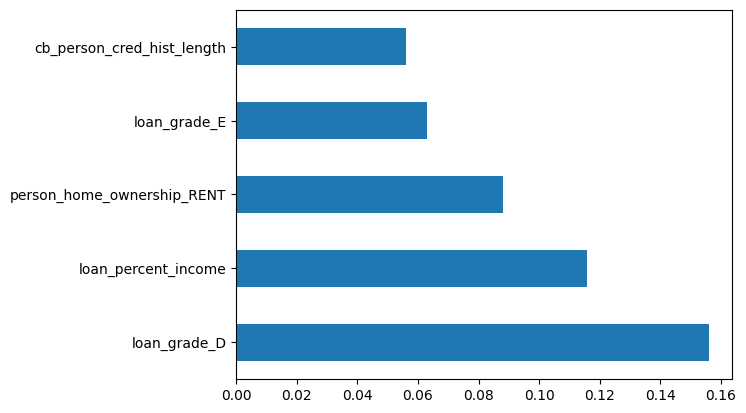

In [ ]:
cat_col=pipe_lgb.named_steps["coltf"].named_transformers_["cat_cols"].get_feature_names_out()
all_cols=list(ncols)+list(cat_col)

# lgb
fi_lgb = pipe_lgb.steps[2][1].feature_importances_
# xgb
fi_xgb = pipe_xgb.steps[2][1].feature_importances_



feat_importances_xgb = pd.Series(fi_xgb, index=all_cols)
feat_importances_xgb.nlargest(5).plot(kind='barh')
plt.fig_size=(4,2)
# XGB feature imp

### **LGBM**

Text(0.5, 1.0, 'LGBM feature importance')

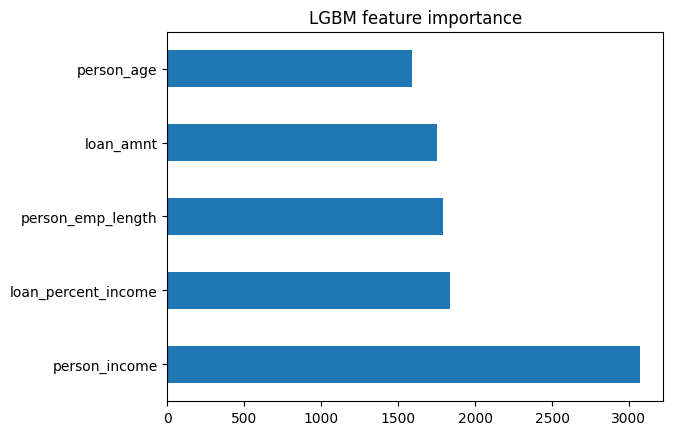

In [ ]:
feat_importances_lgb = pd.Series(fi_lgb, index=all_cols)
feat_importances_lgb.nlargest(5).plot(kind='barh')
plt.fig_size=(4,2)
plt.title('LGBM feature importance')
# LGBM feature imp

### **CatBoost**

In [ ]:
ncols

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_percent_income',
 'cb_person_cred_hist_length']

Text(0.5, 1.0, 'CatBoost feature importance')

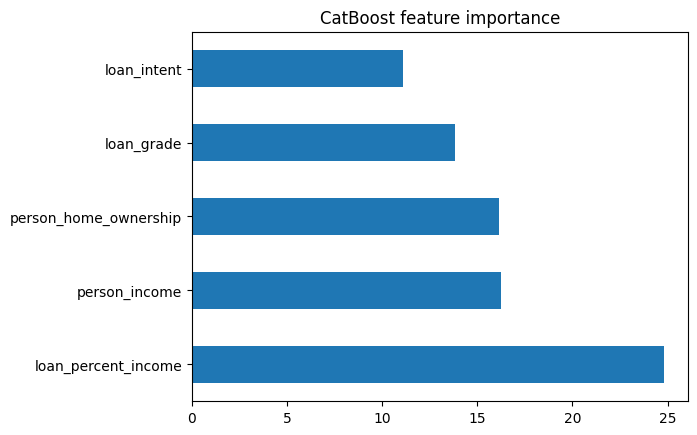

In [ ]:
# feature_imp
fi_cat = be_cat.named_steps['model'].get_feature_importance()

# categorical columns
catb_cols=["person_home_ownership","loan_intent","loan_grade","cb_person_default_on_file"]
# all cols
all_cols=list(ncols)+list(catb_cols)

feat_importances_cat = pd.Series(fi_cat, index=all_cols)
feat_importances_cat.nlargest(5).plot(kind='barh')
plt.fig_size=(4,2)
plt.title('CatBoost feature importance')
# CatBoost feature imp

## **Stacking**

In [ ]:
stacking_model.final_estimator_.coef_

array([[2.23824497, 1.46346401, 4.8518858 ]])

Text(0.5, 0, 'Weight')

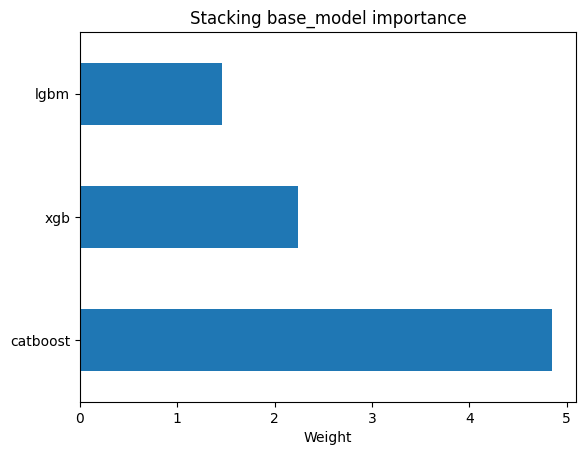

In [ ]:
all_cols_stack=['xgb','lgbm','catboost']


fi_stack = stacking_model.final_estimator_.coef_

feat_importances_stack = pd.Series(fi_stack.flatten(), index=all_cols_stack)
feat_importances_stack.nlargest(5).plot(kind='barh')
plt.fig_size=(4,2)
plt.title('Stacking base_model importance')
plt.xlabel('Weight')
# LGBM feature imp

# **PICKLING**

In [ ]:
import joblib
joblib.dump(pipe_lgb, 'best_pipeline_lgb.pkl')
# using lgbmclassifier pipeline

['best_pipeline_stack.pkl']

In [ ]:
pip freeze

absl-py==1.4.0
accelerate==0.34.2
aiohappyeyeballs==2.4.0
aiohttp==3.10.5
aiosignal==1.3.1
alabaster==0.7.16
albucore==0.0.14
albumentations==1.4.14
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.18.0
asn1crypto==1.5.1
astropy==6.1.3
astropy-iers-data==0.2024.9.2.0.33.23
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.15.0
bigquery-magics==0.2.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.4.3
bqplot==0.12.43
branca==0.7.2
build==1.2.2
CacheControl==0.14.0
cachetools==5.5.0
catalogue==2.0.10
catboost==1.2.7
certifi==2024.8.30
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
clarabel==0.9.0
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.19.0
cloudpickle==2.2.1
cmake==3.30.3
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0

In [ ]:
X.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length'],
      dtype='object')